# Data exploration

We download the data and check which features are numerical and which features are not.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.impute import KNNImputer



# Load the CSV file
file_path = 'train.csv'
data_original = pd.read_csv(file_path)
data = data_original.copy()


all_cols = data.columns
numeric = data.select_dtypes(include=np.number).columns
print("Numerical features: " + ", ".join(numeric))
cat_cols = list(set(all_cols) - set(numeric))
print("Non-numerical features: " + ", ".join(cat_cols))


Numerical features: ID, years_of_experience, A, B, D, prev_salary, label
Non-numerical features: age_group, mental_issues, education, sex, disability, stack_experience, country, C, worked_in_the_past, is_dev


In order to visualize and understand the numeric data, we plot the features in histograms and box plots.

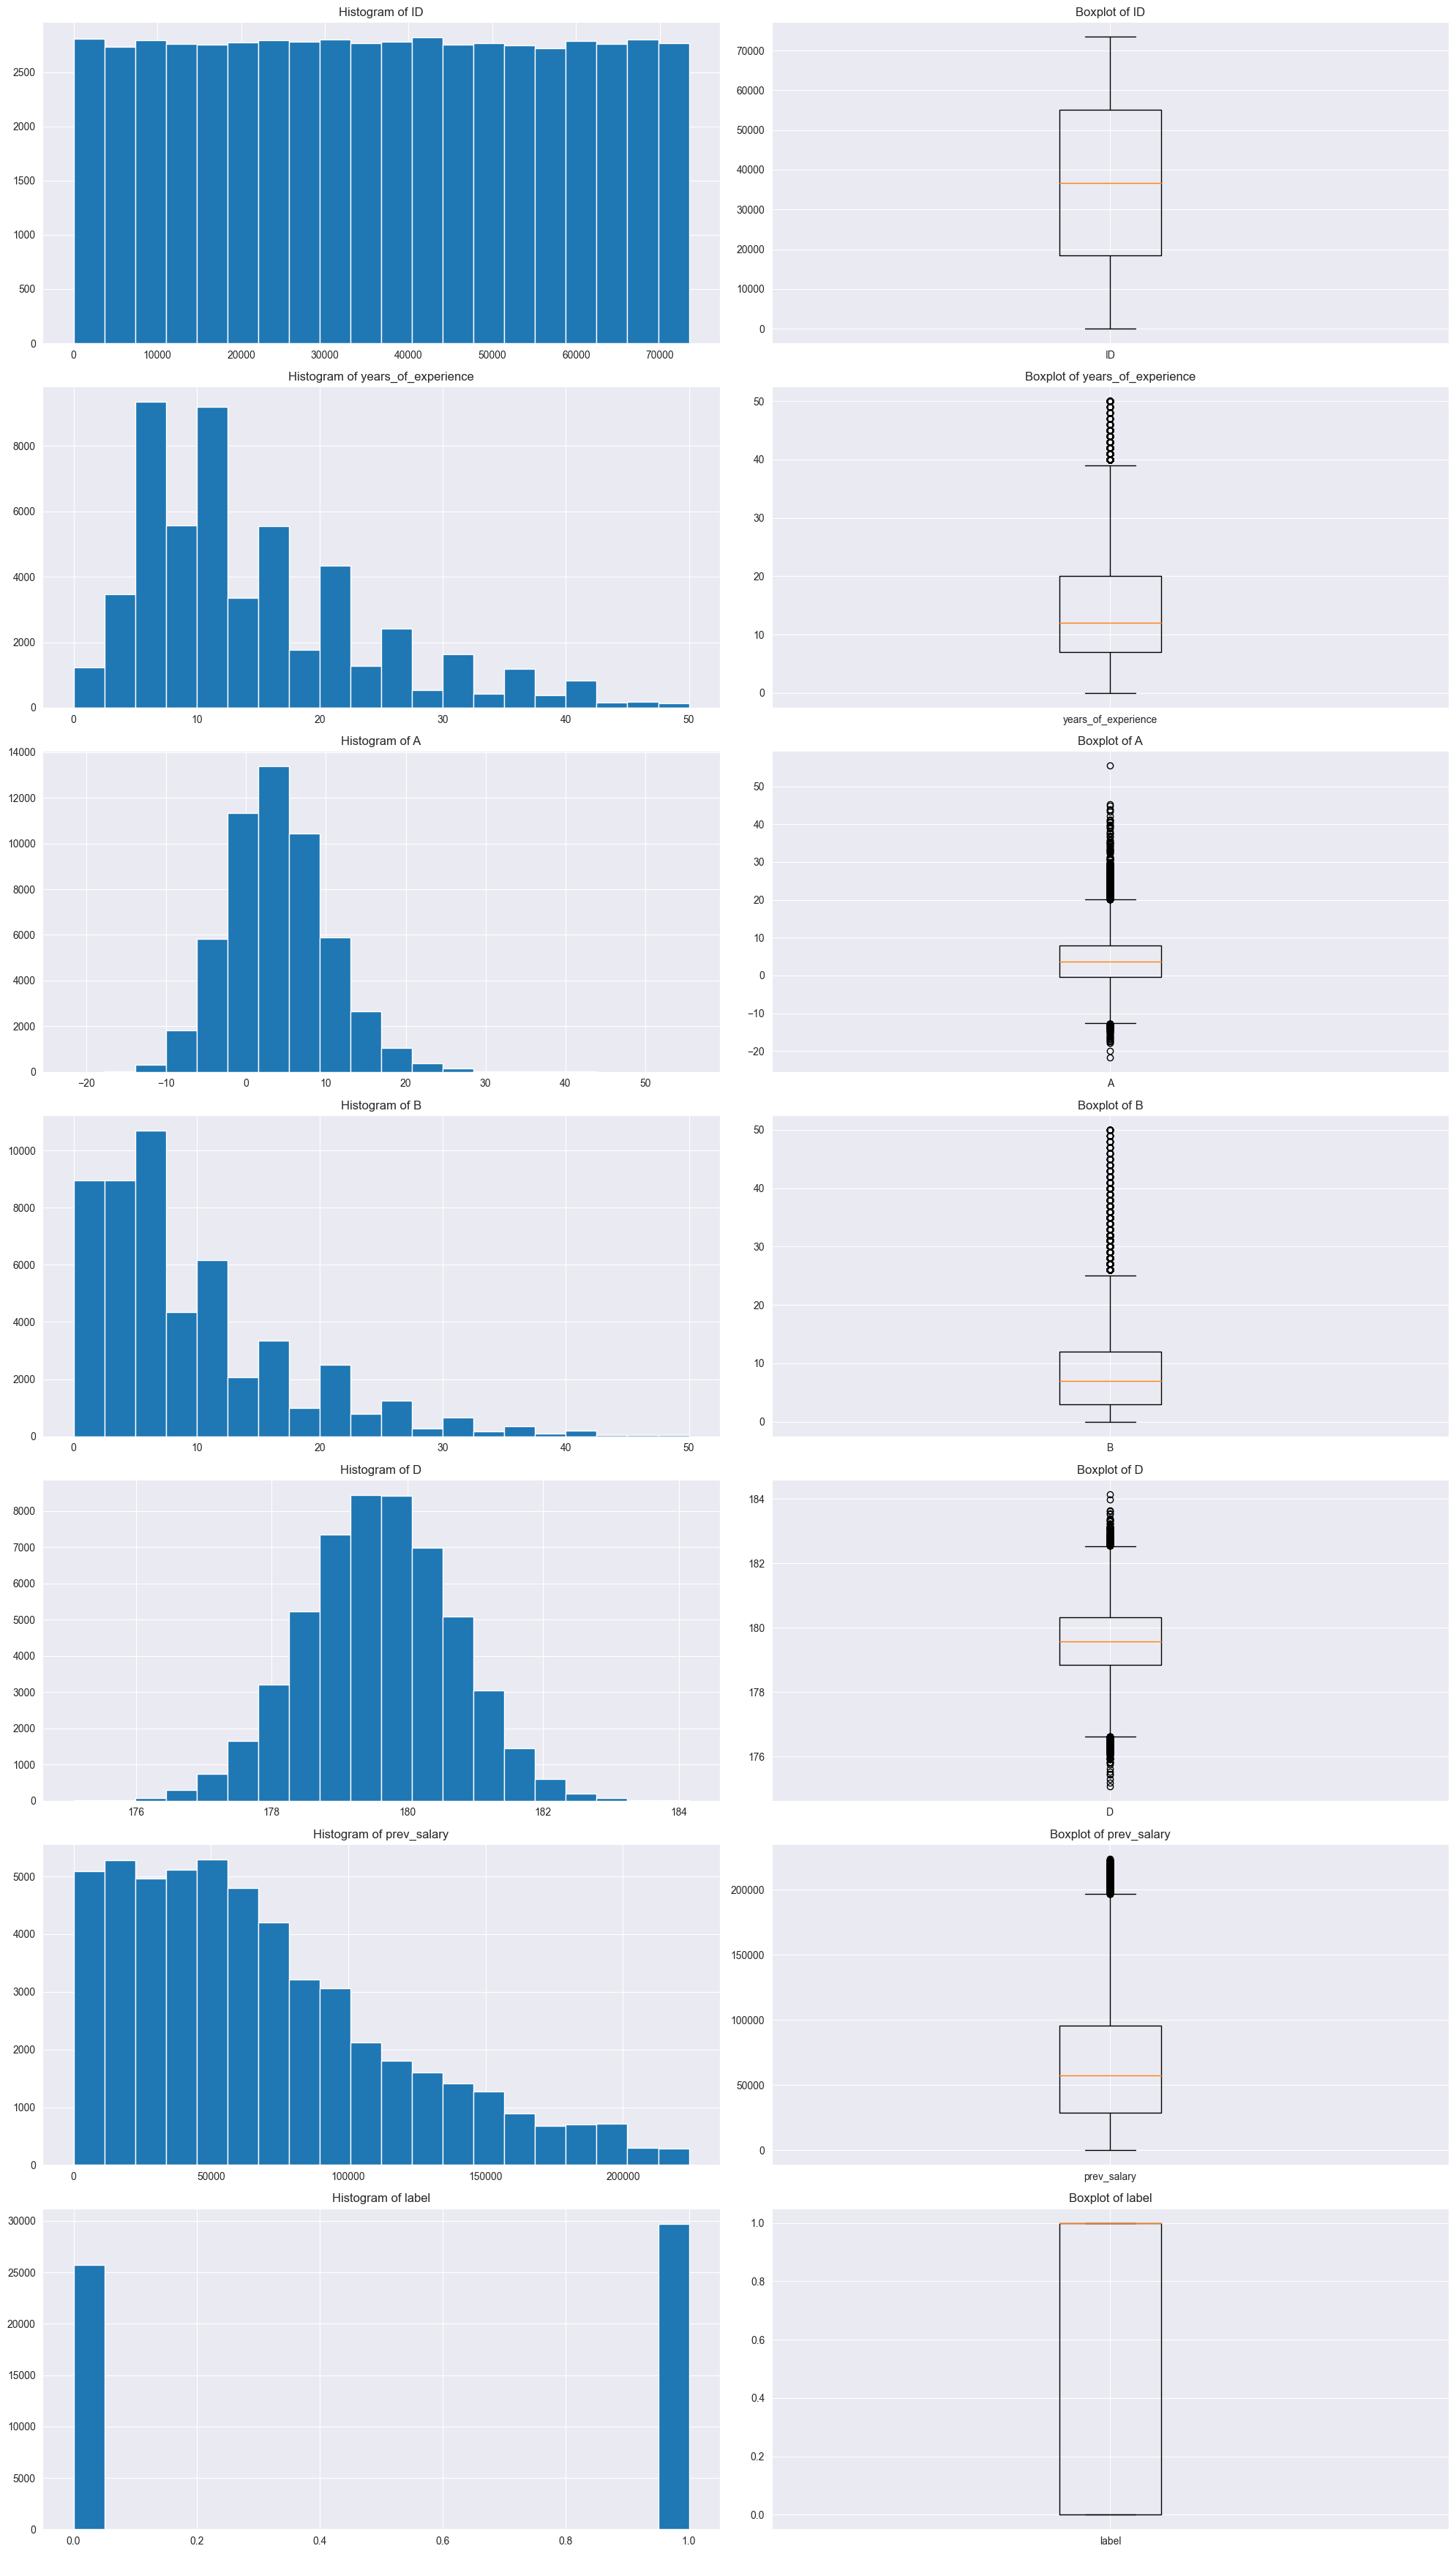

In [2]:
numeric = data.select_dtypes(include=np.number).columns

# Plot histograms for numerical columns
fig, axes = plt.subplots(len(numeric), 2, figsize=(20, 5 * len(numeric)))

for i, col in enumerate(numeric):
    # Histogram
    data[col].hist(bins=20, ax=axes[i, 0])
    axes[i, 0].set_title(f'Histogram of {col}')
    
    # Boxplot using numpy
    axes[i, 1].boxplot(data[col].dropna())
    axes[i, 1].set_title(f'Boxplot of {col}')
    axes[i, 1].set_xticklabels([col])


plt.tight_layout()
plt.show()


In [3]:
data.label.value_counts()

label
1    29740
0    25722
Name: count, dtype: int64

-The ID is irrelevant to the visualisation.
-We can see that around 25722 did not pass and 29740 did pass.
-We observe that "A" and "D" have a normal distribution.
-We observe that in "years_of_experience", "B" and "prev_salaries" most of the values are distributed in a close range and have a few outliers that pull and the median downwards (can be seen in the boxplots). Within the feature engineering, we will pay attention to this.

-Different features have various scales, so we will have to normalize them in the feature engineering.

In order to understand the non-numerical features interaction with the "label" we will run a countplot. 
We exclude "country" and "stack_experience" because they have too many different values and therefore can't be visualized on a plot.
We plot the "label" first to compare its distribution to the other features.

['age_group', 'mental_issues', 'education', 'sex', 'disability', 'stack_experience', 'country', 'C', 'worked_in_the_past', 'is_dev']


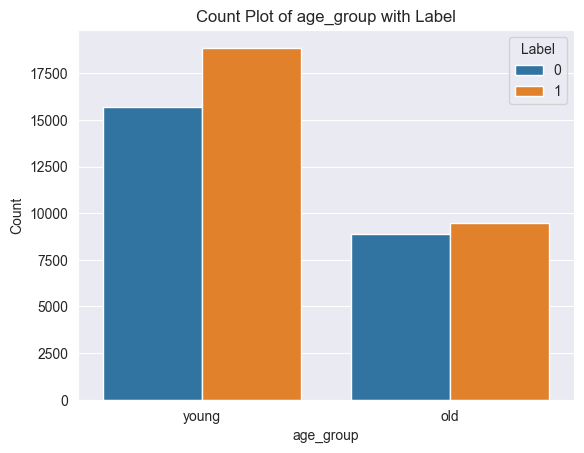

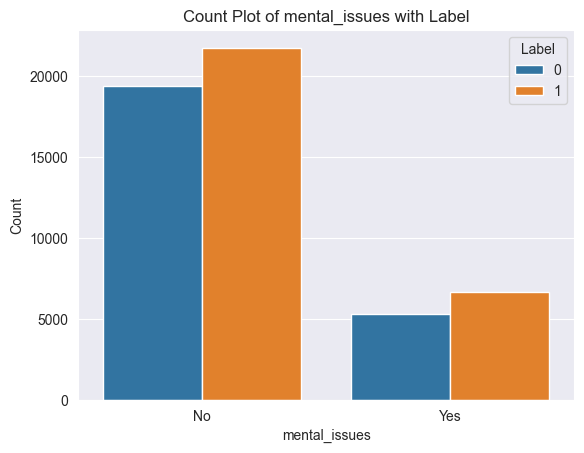

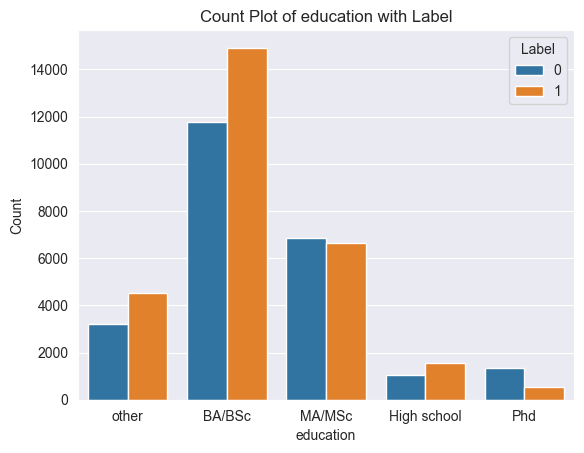

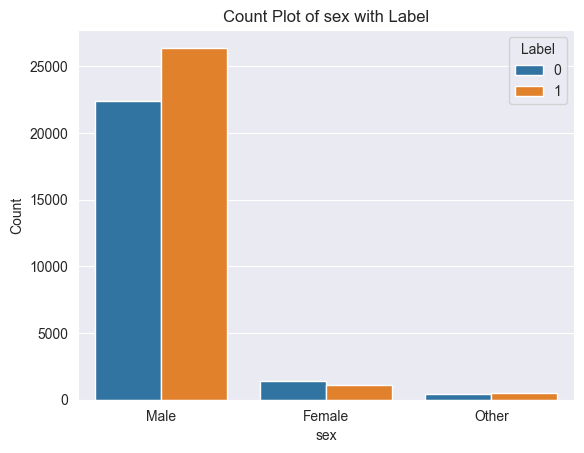

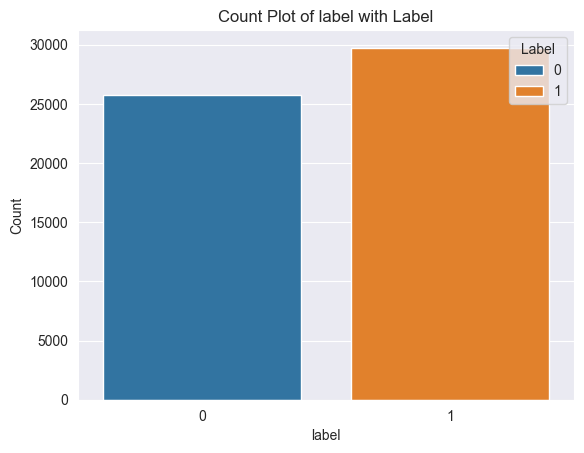

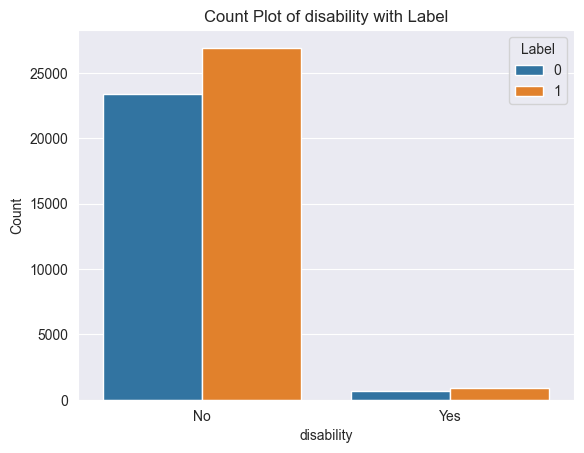

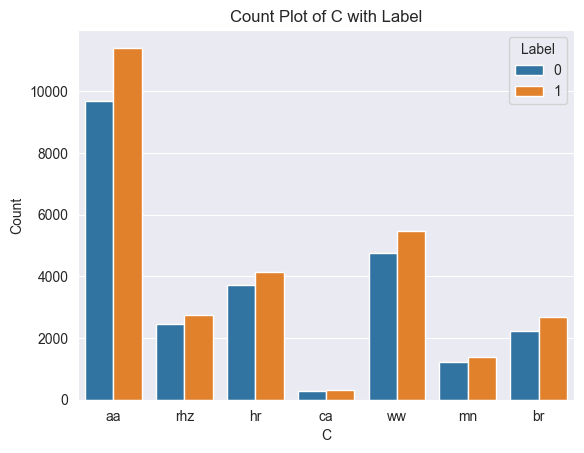

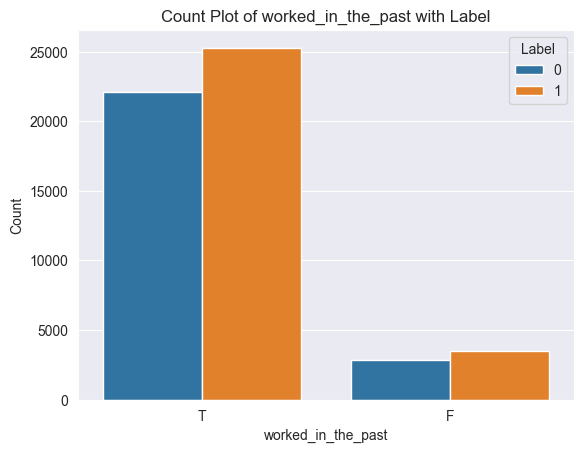

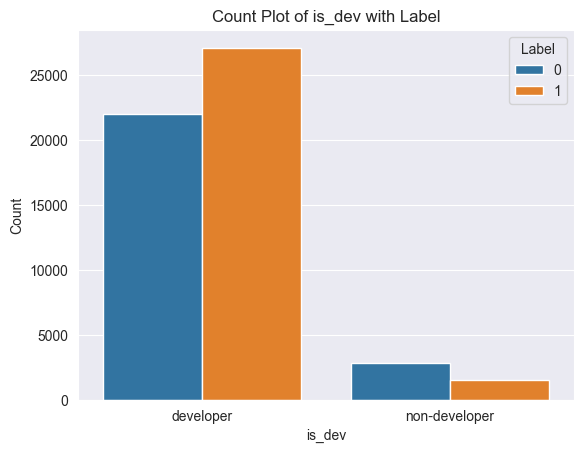

In [4]:
data['label'] = data['label'].astype('category')

print(cat_cols)

# Select non-numerical categorical columns
cat_cols = list(set(data.columns) - set(data.select_dtypes(include=np.number).columns))

# Plot count plots with hue='label' for each non-numeric feature
for col in cat_cols:
    if col != 'country' and col != 'stack_experience':
        plt.figure()
        ax = sns.countplot(x=col, hue='label', data=data)
        plt.title(f'Count Plot of {col} with Label')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.legend(title='Label', loc='upper right')
        plt.show()

We can see that different values in the "C", "disability", "worked_in_the_past" and "mental_issues" do not impact much the prediction and  have a similar distribution to the "label" distribution.

Moreover, We observe that :
-Females are less likely to pass.
-Most of the candidates are males.
-Non-developers are less likely to pass.
-Most of the candidates are developers.
-Old individuals are less likely to pass than young individuals.
-Different types of education interact differently with the likelihood to get hired.

Therefore, we expect the features with the different interactions with the "label", to receive more significant weights in our model.

In order to check if there is correlation between features, we plot a heatmap.

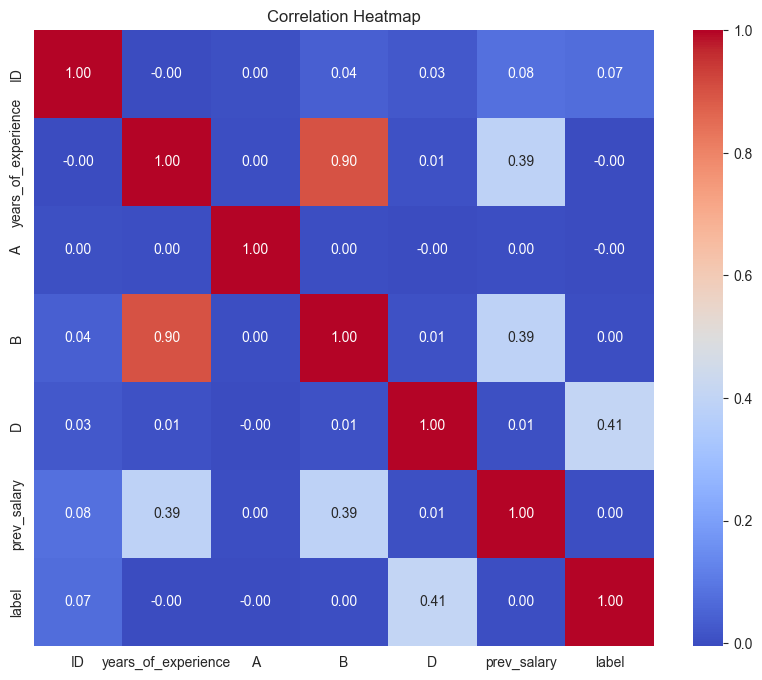

In [5]:
corr_matrix = data[numeric].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f",
            xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns)
plt.title('Correlation Heatmap')
plt.show()

We observe that there is multicollinearity between B and years_of_experience.
Therefore we will most likely not include the both of them in our model.


## FEATURE ENGINEERING


Outlier removal - Numerical features

In [6]:
train_set, val_set = train_test_split(data, test_size=0.2, random_state=42)

# The val will not go through outlier removal


numeric = list(numeric)
numeric.remove("label")
numeric.remove("ID")


multipliers = {
    'A': 2,
    'B': 2.5,
    'years_of_experience': 2,
    'D': 1.5,
    'prev_salary': 1.75
}

# Initialize a mask with all True values (meaning no rows are dropped initially)
outlier_mask = pd.Series([True] * len(train_set), index=train_set.index)

# Apply IQR method with customized multipliers for each numerical feature
for col in numeric:
    Q1 = train_set[col].quantile(0.25)
    Q3 = train_set[col].quantile(0.75)
    IQR = Q3 - Q1
    multiplier = multipliers.get(col, 1.5)  # Default multiplier is 1.5 if not specified
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    
    # Identify outliers
    outliers = (train_set[col] < lower_bound) | (train_set[col] > upper_bound)
    num_outliers = outliers.sum()
    
    print(f"Number of outliers in {col}: {num_outliers}")

    # Update the mask where values are not outliers
    outlier_mask &= ~outliers


# Filter the data to keep only rows without outliers
#We did not filter out the outliers in the end
data_no_outliers = train_set[outlier_mask]


Number of outliers in years_of_experience: 130
Number of outliers in A: 211
Number of outliers in B: 596
Number of outliers in D: 280
Number of outliers in prev_salary: 216


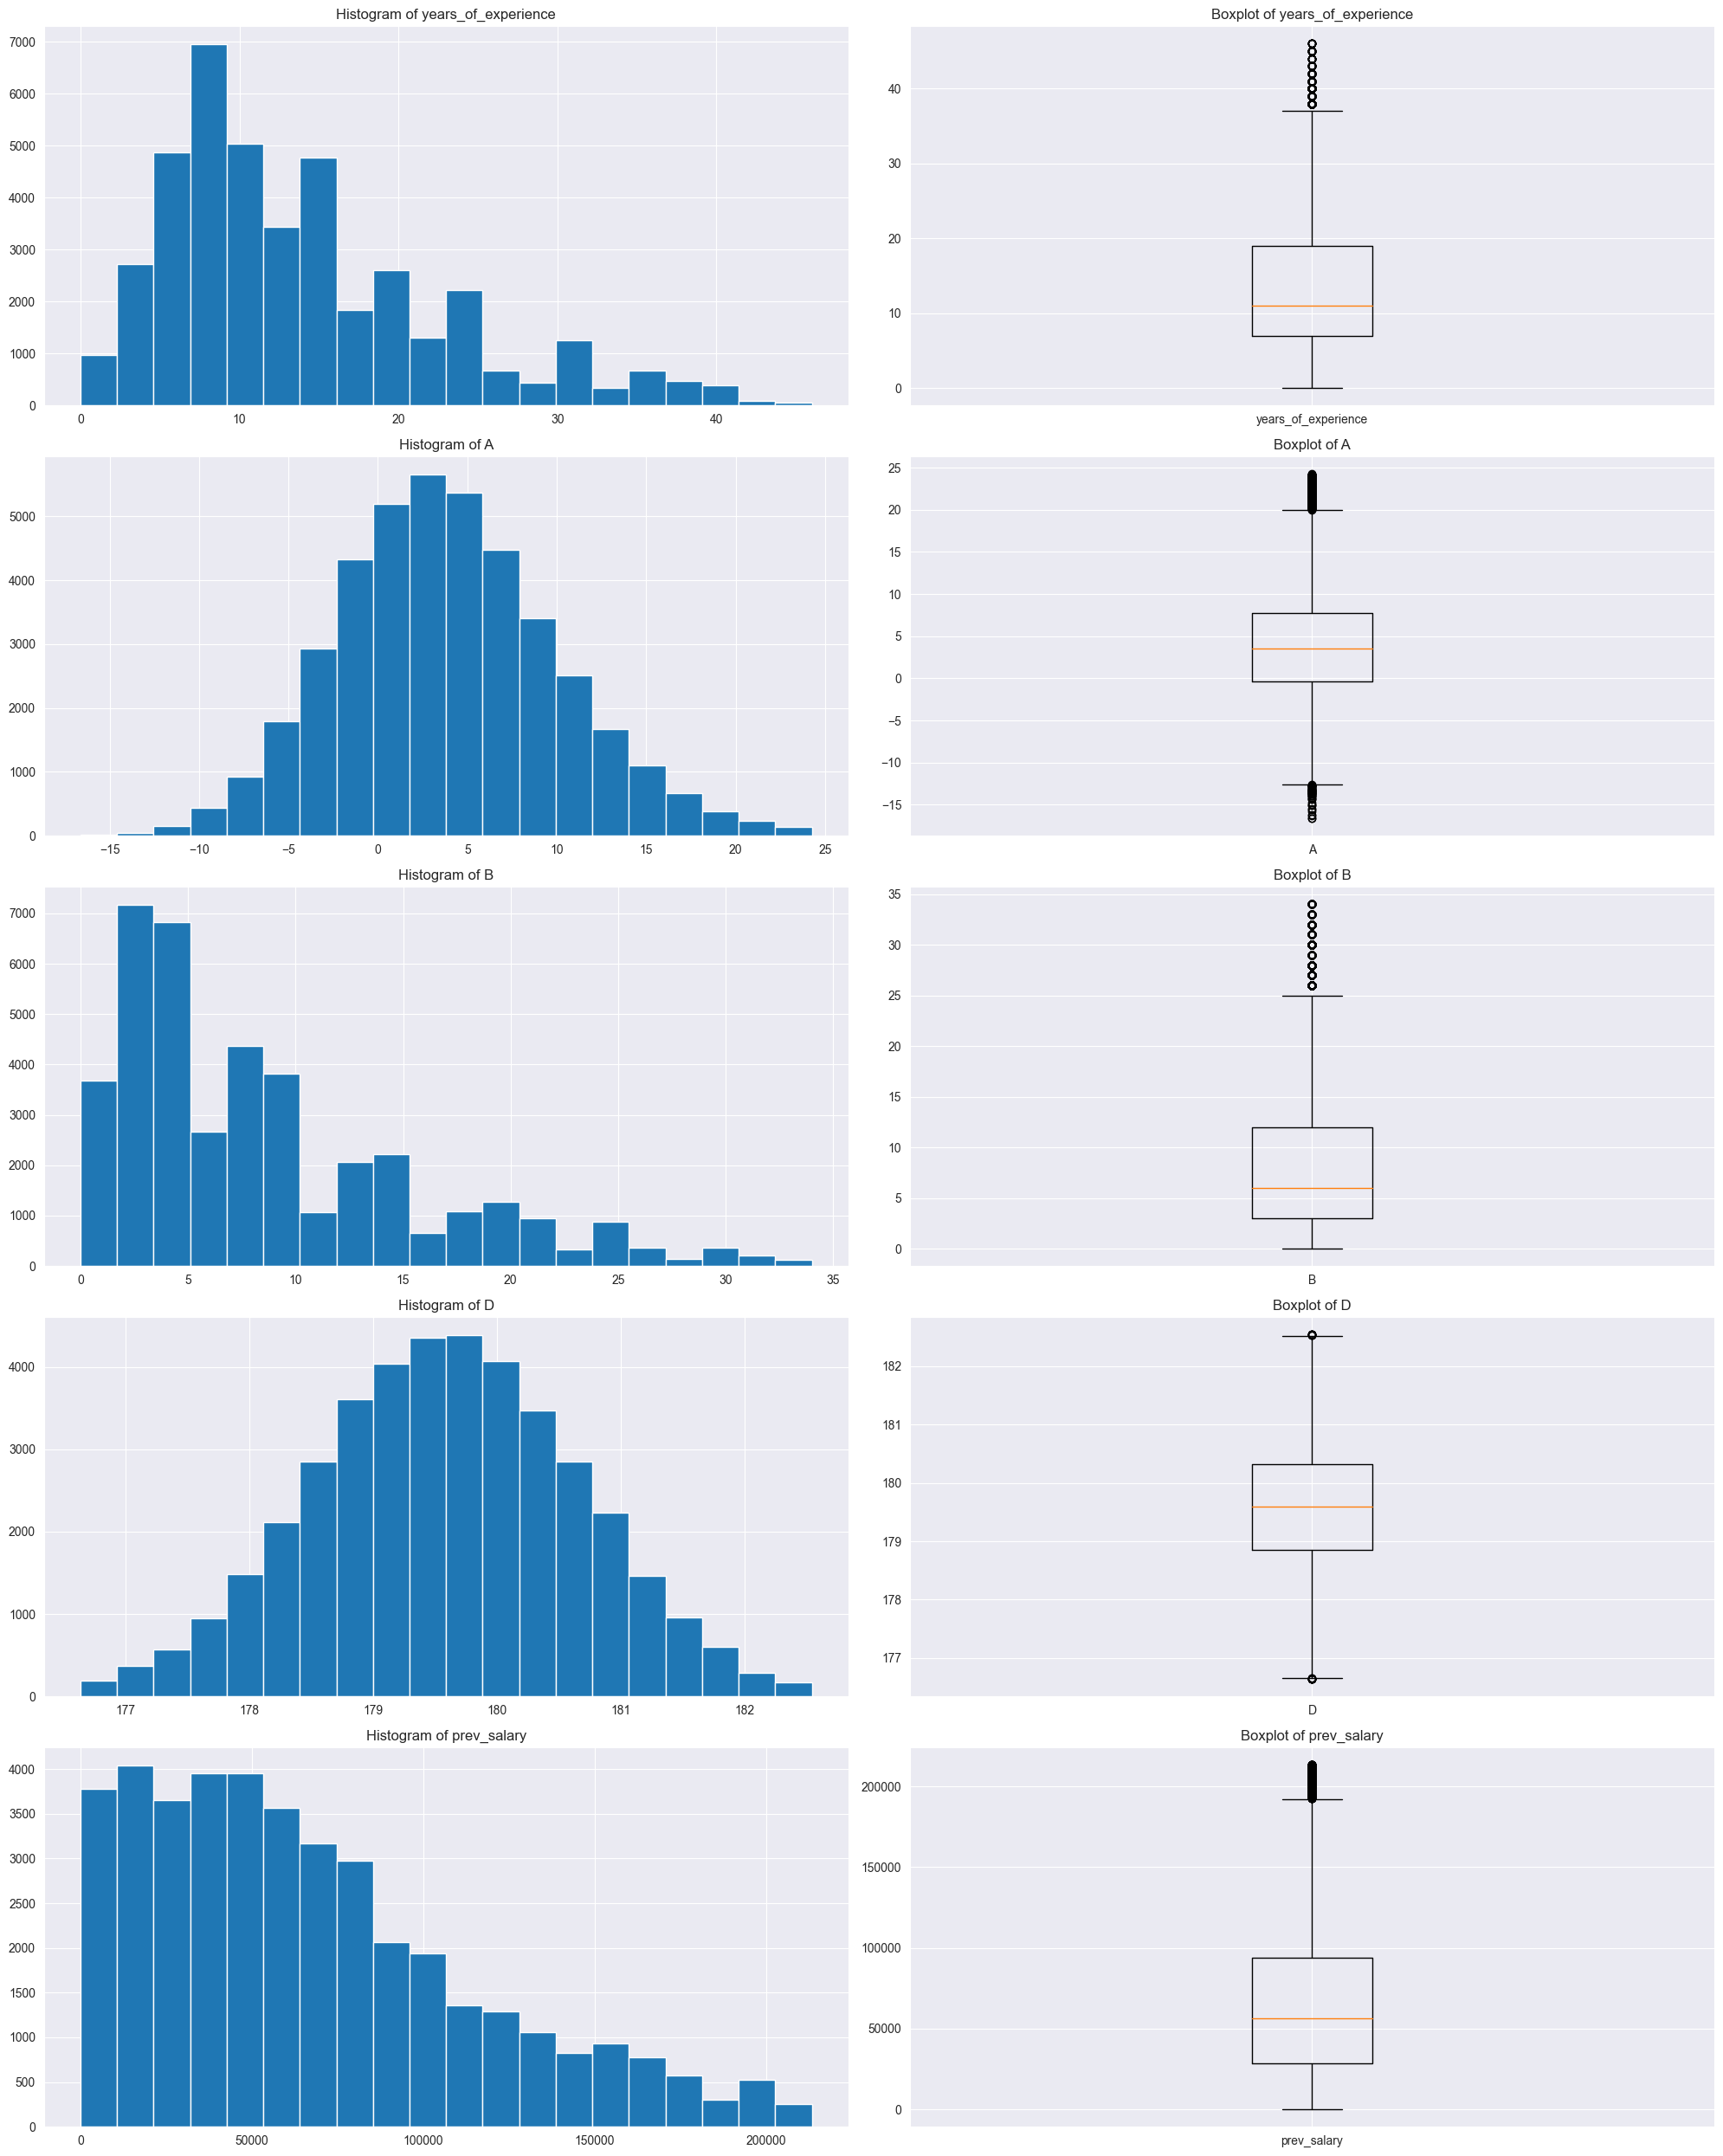

In [7]:
fig, axes = plt.subplots(len(numeric), 2, figsize=(20, 5 * len(numeric)))

for i, col in enumerate(numeric):
    # Histogram
    data_no_outliers[col].hist(bins=20, ax=axes[i, 0])
    axes[i, 0].set_title(f'Histogram of {col}')
    
    # Boxplot using numpy
    axes[i, 1].boxplot(data_no_outliers[col].dropna())
    axes[i, 1].set_title(f'Boxplot of {col}')
    axes[i, 1].set_xticklabels([col])


plt.tight_layout()
plt.show()

train_set = data_no_outliers

The code removes outliers from a dataset using the Interquartile Range (IQR) method with customized multipliers for each numerical feature.
- For each numeric feature, calculate the first quartile (Q1), third quartile (Q3), and the IQR (Q3 - Q1).
- We defined the multipliers for each feature to customize the range for identifying outliers.
- Determine the lower and upper bounds using the IQR and the feature-specific multiplier (defaulting to 1.5 if not specified).
- Filter the data to include only those values within the calculated bounds (i.e., exclude outliers).

We set the multipliers differently to each feature according to our estimation of the feature's distribution - those with a closer to normal distribution will have a lower multiplier, which removes more outliers.

# Normalizing of categorical features + Filling of missing values


We divide the stack_experience into different features using one hot encoding, change the country feature according to the likelihood of each country to pass the interview, and the rest of the categorical features into numerical features by assigning numbers to each category.
We also normalized all data to be between 0 and 1 which reduced our validation AUC so we decided not to normalize.
We filled missing values using KNN imputation.



In [ ]:
train_set['label'] = train_set['label'].astype(float)
original_features = train_set.columns.tolist()

def treat_data(new_data):
    def treat_countries(new_data):
        global country_scores
        new_data['country'] = new_data['country'].map(country_scores)
        return new_data

    def treat_worked(new_data):
        new_data["worked_in_the_past"] = new_data["worked_in_the_past"].replace({"T": 1, "F":0})
        new_data['age_group'] = new_data['age_group']
        return new_data

    def treat_age(new_data):
        new_data["age_group"] = new_data["age_group"].replace({"young": 0, "old":1})
        new_data['age_group'] = new_data['age_group']
        return new_data

    def treat_disability(new_data):
        new_data["disability"] = new_data["disability"].replace({"No": 0, "Yes":1})
        new_data['disability'] = new_data['disability']
        return new_data

    def treat_dev(new_data):
        new_data["is_dev"] = new_data["is_dev"].replace({"developer": 1, "non-developer": 0})
        new_data['is_dev'] = new_data['is_dev']
        return new_data

    def treat_education(new_data):
        education_mapping = {
        'other': 1,
        'High school': 2,  # Assign 2 to "High school" in high school
        'BA/BSc': 3,
        'MA/MSc': 4,
        'Phd': 5
        }
        new_data['education'] = new_data['education'].map(education_mapping)
        return new_data

    def treat_sex(new_data):
        # Mapping for sex
        sex_mapping = {
        'Male': 1,
        'Female': 2,
        'Other': 3,
        }
        new_data['sex'] = new_data['sex'].map(sex_mapping)
        return new_data

    def treat_mental(new_data):
        mental_issues_mapping = {
        'No': 0,
        'Yes': 1,
        }
        new_data['mental_issues'] = new_data['mental_issues'].map(mental_issues_mapping)
        return new_data

    def treat_C(new_data):
        C_mapping = {
        'aa': 1,
        'rhz': 2,
        'hr': 3,
        'ca': 4,
        'ww': 5,
        'mn': 6,
        'br': 7,
        }
        new_data['C'] = new_data['C'].map(C_mapping)
        return new_data
    
    def treat_stack(new_data):
        # Copy the new_data to avoid modifying the original DataFrame
        new_data_temp = new_data.copy()
        
        # Split the 'stack_experience' feature into individual languages
        new_data_temp['languages'] = new_data_temp['stack_experience'].astype(str).str.split(';')
        
        
        # Create a binary column for each language
        all_languages = set(lang.strip() for sublist in new_data_temp['languages'].tolist() for lang in sublist)
        
        for lang in all_languages:
            new_data_temp[lang] = new_data_temp['languages'].apply(lambda x: 1 if lang in x else 0)

        # Drop the original 'stack_experience' and 'languages' columns
        new_data_temp = new_data_temp.drop(columns=['stack_experience', 'languages'])
        
        return new_data_temp
    
    def knn_impute(data, column_name, n_neighbors=5):
        # Initialize the KNNImputer
        imputer = KNNImputer(n_neighbors=n_neighbors)
        # Check if the column exists in the DataFrame
        if column_name not in data.columns:
            raise ValueError(f"Column '{column_name}' not found in the DataFrame.")
        # Extract the column to be imputed
        column_data = data[[column_name]]
        # Perform the KNN imputation
        column_imputed = imputer.fit_transform(column_data)
        # Replace the original column with the imputed values
        data[column_name] = column_imputed
        return data

    def fill_missing_values(data):
        columns = data.columns.tolist()
        for feature in columns:
            data = knn_impute(data, feature, 5)
        return data

        
    new_data = treat_countries(new_data)
    new_data = treat_worked(new_data)
    new_data = treat_age(new_data)
    new_data = treat_disability(new_data)
    new_data = treat_dev(new_data)
    new_data = treat_education(new_data)
    new_data = treat_sex(new_data)
    new_data = treat_mental(new_data)
    new_data = treat_C(new_data)
    new_data = treat_stack(new_data)
    new_data = fill_missing_values(new_data)
    return new_data

data['label'] = data['label'].astype(float)
#Calculate the countries' score
country_scores = data.groupby('country')['label'].agg(['mean', 'count'])
country_scores.loc[country_scores['count'] < 15, 'mean'] = 0.5
country_scores = country_scores['mean'].to_dict()

train_labels = train_set["label"]
train_data = train_set.drop(columns=["label"])
val_labels = val_set["label"]
val_data = val_set.drop(columns=["label"])

train_data = treat_data(train_data)
val_data = treat_data(val_data)

#index features in the same order
val_data = val_data.reindex(columns=train_data.columns, fill_value=0)

# Feature selection

Now, after we normalized the categorical features, we will check the correlation again. In order to see if we can reduce the dimension of our data.<br><br>

The cons of high dimensions are:<br>
- Curse of dimensionality.<br>
- Increase of computational cost.<br>
- Risk of overfitting.<br><br>
Therefore we would like to delete some features if we can.

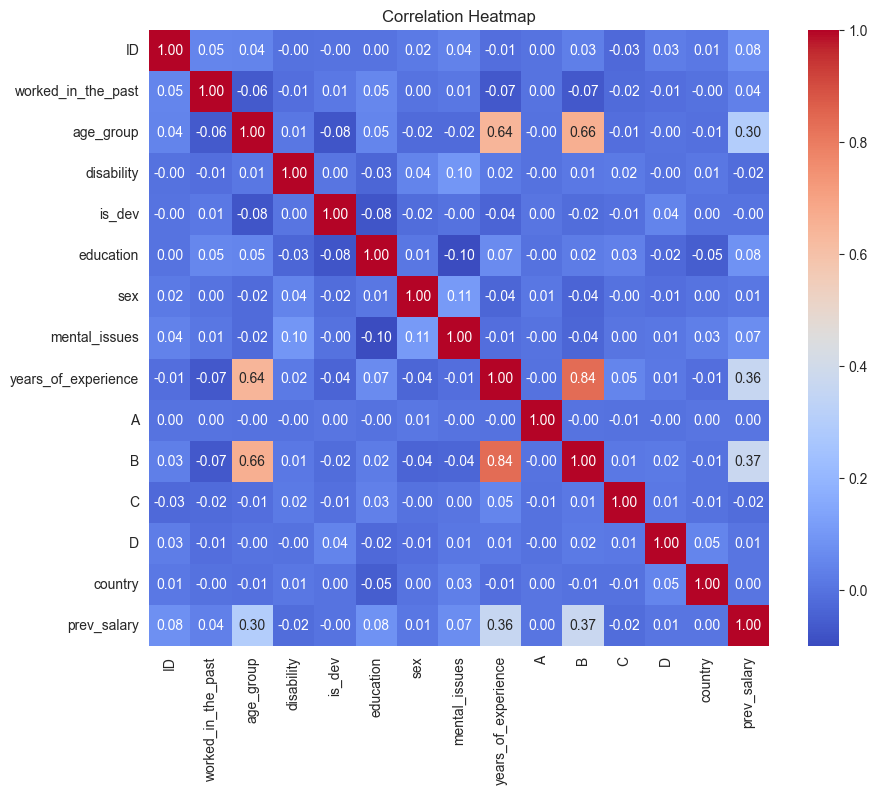

In [9]:
# Calculate the correlation matrix
original_features.remove('stack_experience')
original_features.remove( 'label')
correlation_matrix = train_data[original_features].corr()

# Create the heatmap
plt.figure(figsize=(10, 8))  # You can adjust the size of the heatmap here
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

# Display the heatmap
plt.title('Correlation Heatmap')
plt.show()

We can see a high correlation between "years of experience" and "B", therefore we thought about deleting the B feature.
Later on, we found out that ommiting the B feature reduces the validation AUC so we decided to keep it.
 <br>
In addition we decided to ignore the "ID", because we know it does not effect the label.<br>
We currently have 131 features, the train AUC is higher than the validation AUC, and the runtime is very long.
We will now run feature selection to reduce dimensionality and overfitting, reduce the gap and increase our performance.


# DISCLAIMER: Do not run the next code box as it takes hours to run

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.pipeline import Pipeline

baseline_auc= val_auc
print(f"Baseline Auc: {baseline_auc}")

# Define the Sequential Feature Selector with forward selection
sfs = SequentialFeatureSelector(
    ab_model,
    n_features_to_select='auto',
    direction='forward',
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

# Fit the feature selector
sfs.fit(train_data, train_labels)

# Get the selected features
selected_features = sfs.get_support(indices=True)
print(f"Selected features: {selected_features}")

# Train the model with the selected features
train_data_selected = train_data.iloc[:, selected_features]
val_data_selected = val_data.iloc[:, selected_features]

best_ab_model.fit(train_data_selected, train_labels)
selected_auc = roc_auc_score(val_labels, best_ab_model.predict_proba(val_data_selected)[:, 1])
print(f"ROC AUC with selected features: {selected_auc}")



This code took a long time to run so we hardcoded the selected features.

In [10]:
def feature_selection(df):
    selected_features = ['worked_in_the_past', 'age_group', 'disability', 'is_dev',
                     'education', 'sex', 'mental_issues', 'years_of_experience', 'A',
                     'C', 'D','B' , 'country', 'prev_salary', 'LISP', 'Oracle', 'VMware',
                     'Managed Hosting', 'Laravel', 'SAS', 'Heroku', 'Flask', 'Groovy',
                     'Perl', 'Objective-C', 'Symfony', 'APL', 'Angular.js', 'Elasticsearch',
                     'Spring', 'Drupal', 'Google Cloud Platform', 'C++', 'Rust', 'Crystal',
                     'Scala', 'Oracle Cloud Infrastructure', 'Microsoft SQL Server',
                     'Solidity', 'AWS', 'React.js', 'JavaScript', 'Docker', 'Puppet', 'C#',
                     'Assembly', 'Linode', 'Svelte', 'SQL', 'Git', 'Unreal Engine', 'F#',
                     'Vue.js', 'COBOL', 'Flow', 'TypeScript', 'Node.js', 'SQLite', 'npm',
                     'MongoDB', 'jQuery', 'Java', 'Bash/Shell', 'nan']
    df_selected = df[selected_features]
    return df_selected

train_data = feature_selection(train_data)
val_data = feature_selection(val_data)

We now have 64 features.
After running the model with these features we saw an increase in validation AUC (performance), and a decrease in runtime, which means that we beat the curse of dimensionality and reduced overfitting.

Application on test data

In [ ]:
# Load the CSV file
file_path = 'test.csv'
test_data_original = pd.read_csv(file_path)
test_data = test_data_original.copy()
test_data = treat_data(test_data)
test_data = test_data.reindex(columns=train_data.columns, fill_value=0)
test_data = feature_selection(test_data)

Techniques that were not learned in our lectures:
- Stack experience One Hot Encoding
- Outlier removal using IQR
- Knn imputation

# Models implement

We chose the Gaussian Naive Bayes and the Logistic Regression models.<br>
In the logistic regression, the max_iter parameter controls the maximum number of iterations the algorithm is allowed to run during the optimization process.<br>
In the Naive Bayes, there are no parameters to tune. <br>
The best_max_iter value in the Logistic Regression, found using GridSearchCV is chosen because it provides the best cross-validation performance, ensuring that the Logistic Regression model is well-tuned for the given dataset.<br>

In [12]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_iter': [100, 500, 1000]
}

# Initialize the Logistic Regression model
lr_model = LogisticRegression(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=lr_model, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(train_data, train_labels)

# Get the best parameters
best_params = grid_search.best_params_

# Initialize the models, NB has no hyperparameters
nb_model = GaussianNB()
lr_model = LogisticRegression(max_iter=best_params['max_iter'])

# Train the models
nb_model.fit(train_data, train_labels)
lr_model.fit(train_data, train_labels)


LogisticRegression()

We chose the Random Forest and the AdaBoost models.<br>

The Random Forest parameters:<br>
n_estimators: Controls the number of trees in the forest.<br>
'entropy' uses information gain to guide the decision-making process of the trees.<br>
 More trees generally improve performance but require more computation, reduces variance and have little effect on bias.<br>

AdaBoost Parameters:<br>
base_estimator: The weak learner (decision tree) used in boosting.<br>
n_estimators: Number of weak learners to be combined.<br>
learning_rate: Size of the step: determines how much each weak learner contributes to the final model.<br>

Effect on bias and variance:<br>

max_depth and min_samples_split (for DecisionTreeClassifier):<br>

Higher max_depth: Decreases bias, increases variance.<br>
Higher min_samples_split: Increases bias, decreases variance.<br>

n_estimators (for AdaBoostClassifier):<br>

Increasing: Reduces bias, slightly increases variance.<br>

learning_rate (for AdaBoostClassifier):<br>
Lower: Reduces variance, helps in controlling overfitting, but requires more estimators to achieve the same level of performance.

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report


#Random forest
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'criterion': ['entropy']
}
rf_model = RandomForestClassifier(random_state=42)
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
rf_grid_search.fit(train_data, train_labels)
best_rf_params = rf_grid_search.best_params_
rf_model = RandomForestClassifier(**best_rf_params, random_state=42)
rf_model.fit(train_data, train_labels)


#AdaBoost
ab_param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1, 1.0],
    'base_estimator__max_depth': [3, 5],
    'base_estimator__min_samples_split': [5, 10]
}
base_dt = DecisionTreeClassifier(random_state=42)
ab_model = AdaBoostClassifier(base_estimator=base_dt)
ab_grid_search = GridSearchCV(estimator=ab_model, param_grid=ab_param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
ab_grid_search.fit(train_data, train_labels)
best_ab_params = ab_grid_search.best_params_
best_base_estimator = DecisionTreeClassifier(
    max_depth=best_ab_params['base_estimator__max_depth'],
    min_samples_split=best_ab_params['base_estimator__min_samples_split'],
)
ab_model = AdaBoostClassifier(
    base_estimator=best_base_estimator,
    n_estimators=best_ab_params['n_estimators'],
    learning_rate=best_ab_params['learning_rate'],
)
ab_model.fit(train_data, train_labels)

The importance of every feature to the model:<br>
Using feature importance for Adaboost and Random Forest.<br>
Naive Bayes and Logistic Regression do not have this feature, therefore we calculated normalized absolute coefficient effect on the models' results.

In [14]:
def plot_importance(model, train_data):
    # Get feature importances and feature names
    feature_importances = model.feature_importances_
    feature_names = train_data.columns
    
    # Create a DataFrame for easier sorting
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    })
    
    # Sort the DataFrame by importance in descending order
    importance_df = importance_df.sort_values(by='Importance', ascending=False).iloc[:20]
    
    # Plot the feature importances
    plt.figure(figsize=(10, 8))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title(f'Feature Importances in {type(model).__name__}')
    plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
    plt.show()

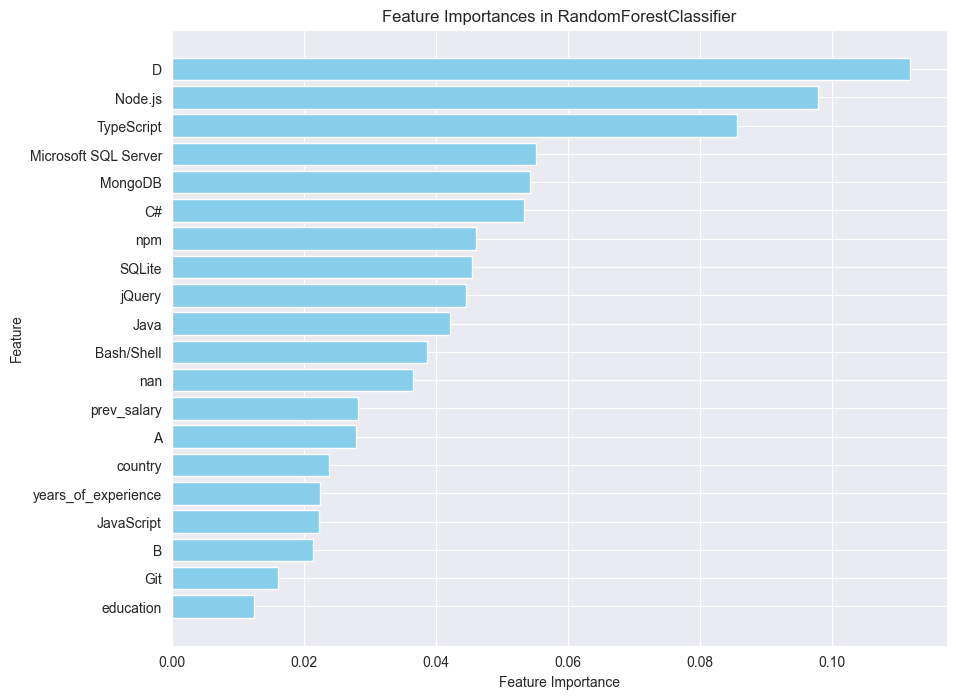

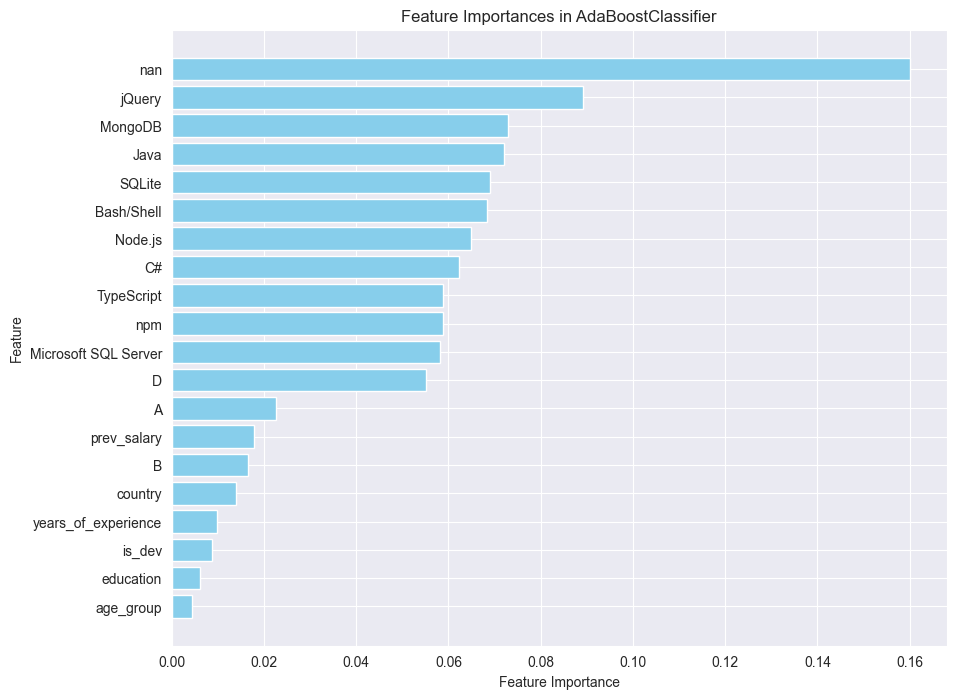

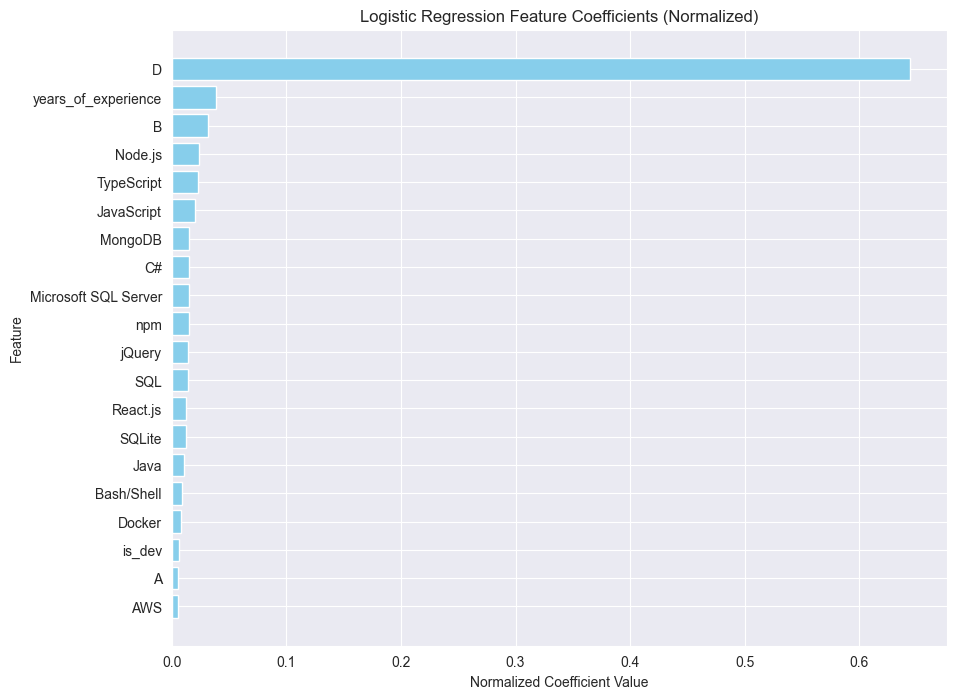

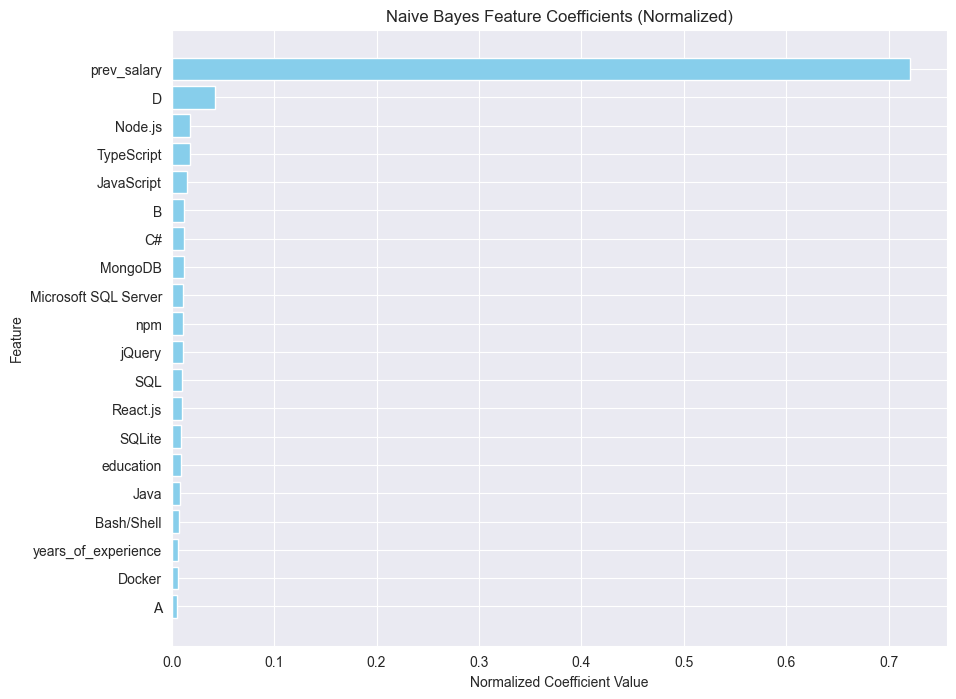

In [15]:
plot_importance(rf_model, train_data)
plot_importance(ab_model, train_data)

def plot_coefficients(model, feature_names, model_name):
    if isinstance(model, LogisticRegression):
        # Logistic Regression coefficients
        coefs = model.coef_[0]
    elif isinstance(model, GaussianNB):
        # GaussianNB doesn't have coef_, so we use theta_ (mean of each feature per class)
        coefs = model.theta_[1] - model.theta_[0]
    else:
        raise ValueError("Model not supported for coefficient plotting.")
    
    # Convert to absolute values
    coefs = np.abs(coefs)
    
    # Normalize to sum up to 1
    coefs = coefs / np.sum(coefs)
    
    # Create a DataFrame for better handling and sorting
    coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefs})
    coef_df = coef_df.sort_values(by='Coefficient', ascending=False).iloc[:20]
    
    # Plot the coefficients
    plt.figure(figsize=(10, 8))
    plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='skyblue')
    plt.xlabel('Normalized Coefficient Value')
    plt.ylabel('Feature')
    plt.title(f'{model_name} Feature Coefficients (Normalized)')
    plt.gca().invert_yaxis()
    plt.show()


plot_coefficients(lr_model, train_data.columns, "Logistic Regression")
plot_coefficients(nb_model, train_data.columns, "Naive Bayes")



# Part 4 - model evaluation

Confusion Matrix:

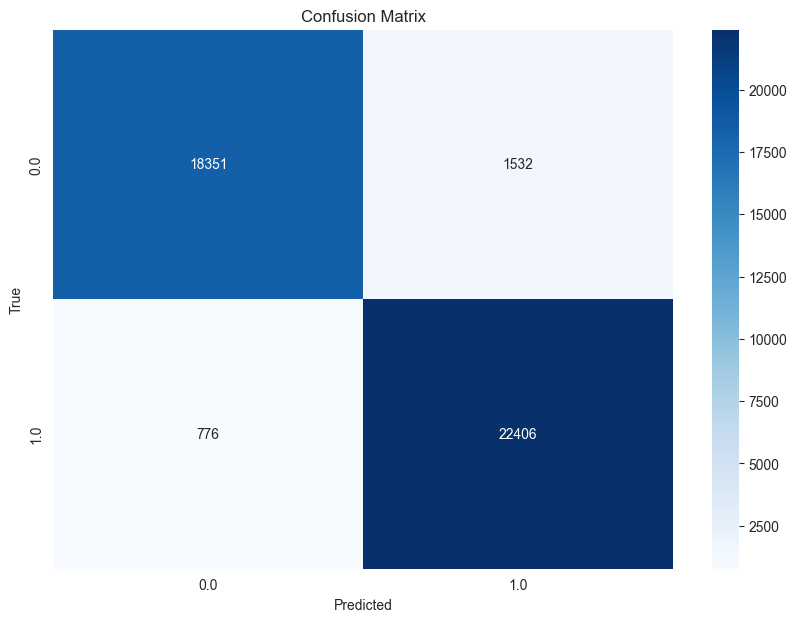

In [16]:
# Make predictions on the train data
pred = rf_model.predict(train_data)

# Compute the confusion matrix
cm = confusion_matrix(train_labels, pred)

# Display the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

True Negatives: 18,351<br>
These are the individuals who were correctly predicted to fail the software interview. This high number indicates the model is good at identifying those who would fail.<br>
False Positives: 1532<br>
These are the individuals who were predicted to pass the software interview but actually failed. This relatively low number suggests that the model makes few incorrect positive predictions.<br>
False Negatives: 776<br>
These are the individuals who were predicted to fail the software interview but actually passed. This relatively low number indicates the model is good at minimizing missed positive cases.<br>
True Positives: 22,406<br>
These are the individuals who were correctly predicted to pass the software interview. This high number indicates the model is good at identifying those who would pass.<br>
Insights:<br>
High True Positive and True Negative Rates: The high values in the diagonal cells (TN and TP) show that the Random Forest model has a high accuracy in predicting both passing and failing cases.<br>
Low False Positive and False Negative Rates: The relatively low values in the off-diagonal cells (FP and FN) indicate that the model makes few errors in both types of incorrect predictions.<br>

Overall, the Random Forest model demonstrates strong predictive performance with high accuracy and low error rates.

Evaluation with n Cross Fold-K and ROC score on each model.

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import KFold


def plot_kfold_roc_curves(train_data, train_labels):
    # Prepare the data
    X = train_data
    y = train_labels

    models = {
        "Random Forest": rf_model,
        "AdaBoost": ab_model,
        "Naive Bayes": nb_model,
        "Logistic Regression": lr_model
    }

    # K-Fold Cross-Validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    plt.figure(figsize=(12, 8))

    for model_name, model in models.items():
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)

        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            model.fit(X_train, y_train)
            if hasattr(model, "predict_proba"):
                y_pred_proba = model.predict_proba(X_test)[:, 1]
            else:
                y_pred_proba = model.decision_function(X_test)

            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            roc_auc = roc_auc_score(y_test, y_pred_proba)
            aucs.append(roc_auc)

            # Interpolate the true positive rates
            tprs.append(np.interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = np.mean(aucs)
        std_auc = np.std(aucs)
        
        plt.plot(mean_fpr, mean_tpr, label=f'{model_name} (AUC = {mean_auc:.2f} ± {std_auc:.2f})')

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Different Models with K-Fold Cross-Validation')
    plt.legend(loc='lower right')
    plt.show()

plot_kfold_roc_curves(train_data, train_labels)

Performance gap between validation and training data:

In [18]:
def compare_validation_training_gap(train_data, train_labels):
    # Prepare the data
    X = train_data
    y = train_labels

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize the models
    models = {
        "Random Forest": rf_model,
        "AdaBoost": ab_model,
        "Naive Bayes": nb_model,
        "Logistic Regression": lr_model
    }

    results = []

    # Train and evaluate the models
    for model_name, model in models.items():
        # Train the model
        model.fit(X_train, y_train)

        # Predict probabilities on training data
        y_train_pred_proba = model.predict_proba(X_train)[:, 1]

        # Predict probabilities on validation data
        y_val_pred_proba = model.predict_proba(X_val)[:, 1]

        # Calculate AUC
        train_auc = roc_auc_score(y_train, y_train_pred_proba)
        val_auc = roc_auc_score(y_val, y_val_pred_proba)
        auc_gap = train_auc - val_auc

        results.append({
            "Model": model_name,
            "Train AUC": train_auc,
            "Validation AUC": val_auc,
            "AUC Gap": auc_gap
        })

    # Convert results to DataFrame for better visualization
    results_df = pd.DataFrame(results)
    return results_df

results_df = compare_validation_training_gap(train_data, train_labels)
print(results_df)

/Users/elieh/PycharmProjects/imgrec/venv/lib/python3.8/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


                 Model  Train AUC  Validation AUC   AUC Gap
0        Random Forest   0.993826        0.972960  0.020866
1             AdaBoost   0.984404        0.981172  0.003232
2          Naive Bayes   0.837565        0.844702 -0.007137
3  Logistic Regression   0.555196        0.556661 -0.001464


It seems that the Random Forest model is overfitted (99% auc on the training data).<br>
In order to prevent it, we should increase the n_estimator parameter. The bias will not change, but the variance should decrease.

We used Optuna, a technique that was not learnt in our course, for meta-learning to optimize the hyperparameters of the AdaBoost model, allowing us to find the best combination of parameters to maximize the AUC score. This approach outperforms traditional grid search by efficiently exploring a wider range of hyperparameter values.

# DISCLAIMER: This also takes a long time to run so we hardcoded the best parameters into our chosen model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
import optuna
from sklearn.model_selection import cross_val_score

# Define the objective function for Optuna
def objective(trial):
    print("Hello World")
    # Define the hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 50, 4000)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 1.0)
    max_depth = trial.suggest_int('max_depth', 1, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 50)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 50)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    splitter = trial.suggest_categorical('splitter', ['best', 'random'])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    # Create the model with the current hyperparameters
    estimator = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        splitter=splitter,
        criterion=criterion
    )
    model = AdaBoostClassifier(
        estimator=estimator,
        n_estimators=n_estimators,
        learning_rate=learning_rate
    )

    # Perform cross-validation
    score = cross_val_score(model, train_data, train_labels, cv=5, scoring='roc_auc').mean()
    return score

# Create the study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, n_jobs=-1)

# Get the best hyperparameters
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

# Extract the best hyperparameters
best_n_estimators = best_params['n_estimators']
best_learning_rate = best_params['learning_rate']
best_max_depth = best_params['max_depth']
best_min_samples_split = best_params['min_samples_split']
best_min_samples_leaf = best_params['min_samples_leaf']
best_max_features = best_params['max_features']
best_splitter = best_params['splitter']
best_criterion = best_params['criterion']

# Train the final model
final_estimator = DecisionTreeClassifier(
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split,
    min_samples_leaf=best_min_samples_leaf,
    max_features=best_max_features,
    splitter=best_splitter,
    criterion=best_criterion
)
final_model = AdaBoostClassifier(
    estimator=final_estimator,
    n_estimators=best_n_estimators,
    learning_rate=best_learning_rate
)
final_model.fit(train_data, train_labels)

# Evaluate the final model
y_train_pred_proba = final_model.predict_proba(train_data)[:, 1]
train_auc = roc_auc_score(train_labels, y_train_pred_proba)
print(f"Training AUC: {train_auc}")

# If you have a validation set
y_val_pred_proba = final_model.predict_proba(val_data)[:, 1]
val_auc = roc_auc_score(val_labels, y_val_pred_proba)
print(f"Validation AUC: {val_auc}")


The meta-learning function found out that these were the optimal hyperparameters for our data and model:

{'n_estimators': 3579, 'learning_rate': 0.007013099676402693, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 38, 'max_features': 'log2', 'splitter': 'random', 'criterion': 'gini'}





# Prediction

In [ ]:
#retrain model on all train data
train_set = data_original.copy()
train_set['label'] = train_set['label'].astype(float)
train_labels = train_set["label"]
train_data = train_set.drop(columns=["label"])
#Calculate the countries' score again
country_scores = train_set.groupby('country')['label'].agg(['mean', 'count'])
country_scores.loc[country_scores['count'] < 15, 'mean'] = 0.5
country_scores = country_scores['mean'].to_dict()
train_data = treat_data(train_data)
train_data = feature_selection(train_data)
#MODEL  
best_ab_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=6, min_samples_split=5, min_samples_leaf=38, max_features='log2', splitter='random', criterion='gini'),
    n_estimators=3579,
    learning_rate=0.007013099676402693
)
best_ab_model.fit(train_data, train_labels)


#PREDICTION
test_pred_proba = best_ab_model.predict_proba(test_data)[:, 1]
results = pd.DataFrame({'ID': test_data_original['ID'], 'prediction': test_pred_proba})
results.to_csv('results_27.csv', index=False)

# FINAL PIPELINE - This code block is enough to predict the probabilities

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.impute import KNNImputer


def treat_data(new_data):
    def treat_countries(new_data):
        global country_scores
        new_data['country'] = new_data['country'].map(country_scores)
        return new_data

    def treat_worked(new_data):
        new_data["worked_in_the_past"] = new_data["worked_in_the_past"].replace({"T": 1, "F":0})
        new_data['age_group'] = new_data['age_group']
        return new_data

    def treat_age(new_data):
        new_data["age_group"] = new_data["age_group"].replace({"young": 0, "old":1})
        new_data['age_group'] = new_data['age_group']
        return new_data

    def treat_disability(new_data):
        new_data["disability"] = new_data["disability"].replace({"No": 0, "Yes":1})
        new_data['disability'] = new_data['disability']
        return new_data

    def treat_dev(new_data):
        new_data["is_dev"] = new_data["is_dev"].replace({"developer": 1, "non-developer": 0})
        new_data['is_dev'] = new_data['is_dev']
        return new_data

    def treat_education(new_data):
        education_mapping = {
        'other': 1,
        'High school': 2,  # Assign 2 to "High school" in high school
        'BA/BSc': 3,
        'MA/MSc': 4,
        'Phd': 5
        }

        new_data['education'] = new_data['education'].map(education_mapping)
        return new_data

    def treat_sex(new_data):
        # Mapping for sex
        sex_mapping = {
        'Male': 1,
        'Female': 2,
        'Other': 3,
        }
        new_data['sex'] = new_data['sex'].map(sex_mapping)
        return new_data

    def treat_mental(new_data):
        mental_issues_mapping = {
        'No': 0,
        'Yes': 1,
        }
        new_data['mental_issues'] = new_data['mental_issues'].map(mental_issues_mapping)
        return new_data

    def treat_C(new_data):
        C_mapping = {
        'aa': 1,
        'rhz': 2,
        'hr': 3,
        'ca': 4,
        'ww': 5,
        'mn': 6,
        'br': 7,
        }
        new_data['C'] = new_data['C'].map(C_mapping)
        return new_data
    
    def treat_stack(new_data):
        # Copy the new_data to avoid modifying the original DataFrame
        new_data_temp = new_data.copy()
        
        # Split the 'stack_experience' feature into individual languages
        new_data_temp['languages'] = new_data_temp['stack_experience'].astype(str).str.split(';')
        
        
        # Create a binary column for each language
        all_languages = set(lang.strip() for sublist in new_data_temp['languages'].tolist() for lang in sublist)
        
        for lang in all_languages:
            new_data_temp[lang] = new_data_temp['languages'].apply(lambda x: 1 if lang in x else 0)

        # Drop the original 'stack_experience' and 'languages' columns
        new_data_temp = new_data_temp.drop(columns=['stack_experience', 'languages'])
        
        return new_data_temp
    
    def knn_impute(data, column_name, n_neighbors=5):
        # Initialize the KNNImputer
        imputer = KNNImputer(n_neighbors=n_neighbors)
        # Check if the column exists in the DataFrame
        if column_name not in data.columns:
            raise ValueError(f"Column '{column_name}' not found in the DataFrame.")
        # Extract the column to be imputed
        column_data = data[[column_name]]
        # Perform the KNN imputation
        column_imputed = imputer.fit_transform(column_data)
        # Replace the original column with the imputed values
        data[column_name] = column_imputed
        return data

    def fill_missing_values(data):
        columns = data.columns.tolist()
        for feature in columns:
            data = knn_impute(data, feature, 5)
        return data

        
    new_data = treat_countries(new_data)
    new_data = treat_worked(new_data)
    new_data = treat_age(new_data)
    new_data = treat_disability(new_data)
    new_data = treat_dev(new_data)
    new_data = treat_education(new_data)
    new_data = treat_sex(new_data)
    new_data = treat_mental(new_data)
    new_data = treat_C(new_data)
    new_data = treat_stack(new_data)
    new_data = fill_missing_values(new_data)
    return new_data


def feature_selection(df):
    selected_features = ['worked_in_the_past', 'age_group', 'disability', 'is_dev',
                     'education', 'sex', 'mental_issues', 'years_of_experience', 'A',
                     'C', 'D','B' , 'country', 'prev_salary', 'LISP', 'Oracle', 'VMware',
                     'Managed Hosting', 'Laravel', 'SAS', 'Heroku', 'Flask', 'Groovy',
                     'Perl', 'Objective-C', 'Symfony', 'APL', 'Angular.js', 'Elasticsearch',
                     'Spring', 'Drupal', 'Google Cloud Platform', 'C++', 'Rust', 'Crystal',
                     'Scala', 'Oracle Cloud Infrastructure', 'Microsoft SQL Server',
                     'Solidity', 'AWS', 'React.js', 'JavaScript', 'Docker', 'Puppet', 'C#',
                     'Assembly', 'Linode', 'Svelte', 'SQL', 'Git', 'Unreal Engine', 'F#',
                     'Vue.js', 'COBOL', 'Flow', 'TypeScript', 'Node.js', 'SQLite', 'npm',
                     'MongoDB', 'jQuery', 'Java', 'Bash/Shell', 'nan']
    df_selected = df[selected_features]
    return df_selected

# Load the train CSV file
file_path = 'train.csv'
data_original = pd.read_csv(file_path)
train_set = data_original.copy()

# Load the test CSV file
file_path = 'test.csv'
test_data_original = pd.read_csv(file_path)
test_data = test_data_original.copy()

#Divide train set into features and labels
train_set['label'] = train_set['label'].astype(float)
train_labels = train_set["label"]
train_data = train_set.drop(columns=["label"])

#Calculate the countries' score
country_scores = train_set.groupby('country')['label'].agg(['mean', 'count'])
country_scores.loc[country_scores['count'] < 15, 'mean'] = 0.5
country_scores = country_scores['mean'].to_dict()

#Normalizing
train_data = treat_data(train_data)
test_data = treat_data(test_data)

#index features in the same order
test_data = test_data.reindex(columns=train_data.columns, fill_value=0)
train_data = feature_selection(train_data)
test_data = feature_selection(test_data)


#MODEL  
best_ab_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=6, min_samples_split=5, min_samples_leaf=38, max_features='log2', splitter='random', criterion='gini'),
    n_estimators=3579,
    learning_rate=0.007013099676402693
)
best_ab_model.fit(train_data, train_labels)

test_pred_proba = best_ab_model.predict_proba(test_data)[:, 1]
results = pd.DataFrame({'ID': test_data_original['ID'], 'prediction': test_pred_proba})
results.to_csv('results_27.csv', index=False)